# Example of usage Spark OCR with Dicom Image Deidentifier

## Install spark-ocr python packge
Need specify:
- license
- path to `spark-ocr-assembly-[version].jar` and `spark-nlp-jsl-[version]`
- or `secret` for Spark OCR and `nlp_secret` for Spark NLP Internal
- `aws_access_key` and `aws_secret_key`for download pretrained models

## Setup

In [ ]:
import os
import matplotlib.pyplot as plt
from sparknlp.annotator import *
from sparknlp.base import *
import sparknlp_jsl
from sparknlp_jsl.annotator import *
import sparkocr
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import display_image, to_pil_image

import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

spark = start_spark()
print("Spark OCR Version :", sparkocr.version())

In [ ]:
!gdown 1e2xnujGxcl0n0mTPNcV_YdlDx0V3NDMS

In [ ]:
%pip install matplotlib

In [ ]:
## Import Spark OCR transformers and Spark NLP annotators

In [ ]:
## Define de-identification  NLP pipeline

In [ ]:
def deidentification_nlp_pipeline(input_column, prefix = ""):
    document_assembler = DocumentAssembler() \
        .setInputCol(input_column) \
        .setOutputCol(prefix + "document")

    # Sentence Detector annotator, processes various sentences per line
    sentence_detector = SentenceDetector() \
        .setInputCols([prefix + "document"]) \
        .setOutputCol(prefix + "sentence")

    tokenizer = Tokenizer() \
        .setInputCols([prefix + "sentence"]) \
        .setOutputCol(prefix + "token")

    # Clinical word embeddings
    word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models") \
        .setInputCols([prefix + "sentence", prefix + "token"]) \
        .setOutputCol(prefix + "embeddings")
    # NER model trained on i2b2 (sampled from MIMIC) dataset
    clinical_ner = MedicalNerModel.pretrained("ner_deid_large", "en", "clinical/models") \
        .setInputCols([prefix + "sentence", prefix + "token", prefix + "embeddings"]) \
        .setOutputCol(prefix + "ner")

    custom_ner_converter = NerConverter() \
        .setInputCols([prefix + "sentence", prefix + "token", prefix + "ner"]) \
        .setOutputCol(prefix + "ner_chunk") \
        .setWhiteList(['NAME', 'AGE', 'CONTACT', 'LOCATION', 'PROFESSION', 'PERSON', 'DATE'])

    nlp_pipeline = Pipeline(stages=[
            document_assembler,
            sentence_detector,
            tokenizer,
            word_embeddings,
            clinical_ner,
            custom_ner_converter
        ])
    empty_data = spark.createDataFrame([[""]]).toDF(input_column)
    nlp_model = nlp_pipeline.fit(empty_data)
    return nlp_model

In [ ]:
## Define OCR transformers and pipeline

In [ ]:
# Convert to images
binary_to_image = BinaryToImage() \
    .setInputCol("content") \
    .setOutputCol("image_raw")

# Extract text from image
ocr = ImageToText() \
    .setInputCol("image_raw") \
    .setOutputCol("text") \
    .setIgnoreResolution(False) \
    .setPageIteratorLevel(PageIteratorLevel.SYMBOL) \
    .setPageSegMode(PageSegmentationMode.SPARSE_TEXT) \
    .setConfidenceThreshold(70)

# Found coordinates of sensitive data
position_finder = PositionFinder() \
    .setInputCols("ner_chunk") \
    .setOutputCol("coordinates") \
    .setPageMatrixCol("positions") \
    .setPadding(1)

# Draw filled rectangle for hide sensitive data
drawRegions = ImageDrawRegions()  \
    .setInputCol("image_raw")  \
    .setInputRegionsCol("coordinates")  \
    .setOutputCol("image_with_regions")  \
    .setFilledRect(True) \
    .setRectColor(Color.gray)
    

# OCR pipeline
pipeline = Pipeline(stages=[
    binary_to_image,
    ocr,
    deidentification_nlp_pipeline(input_column="text"),
    position_finder,
    drawRegions
])

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_deid_large download started this may take some time.
[OK!]


19:15:16, INFO NumExpr defaulting to 2 threads.


## Load image

In [ ]:
import pkg_resources
image_path = pkg_resources.resource_filename('sparkocr', 'resources/ocr/images/p1.jpg')
image_df = spark.read.format("binaryFile").load(image_path)

## Run pipeline

In [ ]:
result = pipeline.fit(image_df).transform(image_df).cache()

## Display chunks which need to hide

In [ ]:
# NBVAL_SKIP
result.select('ner_chunk').show(2, False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|ner_chunk                                                                                                                                                                                                                                                                                                   |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[{chunk, 193, 202, 04/04/2018, {entity -> DATE, sentence -> 1, chunk -> 0, confidence -> 0

## Display coordinates of chunks which need to hide

In [ ]:
# NBVAL_SKIP
result.select('coordinates').show(2, False)

+-------------------------------------------------------------------------------------------------------------------------------------------------+
|coordinates                                                                                                                                      |
+-------------------------------------------------------------------------------------------------------------------------------------------------+
|[{0, 0, 356.0, 1053.0, 217.0, 41.0, 0.0, 0, 0.0}, {1, 0, 1305.0, 2011.0, 9.0, 9.0, 0.0, 0, 0.0}, {2, 0, 495.0, 3527.0, 231.0, 43.0, 0.0, 0, 0.0}]|
+-------------------------------------------------------------------------------------------------------------------------------------------------+



## Show original and de-identified images

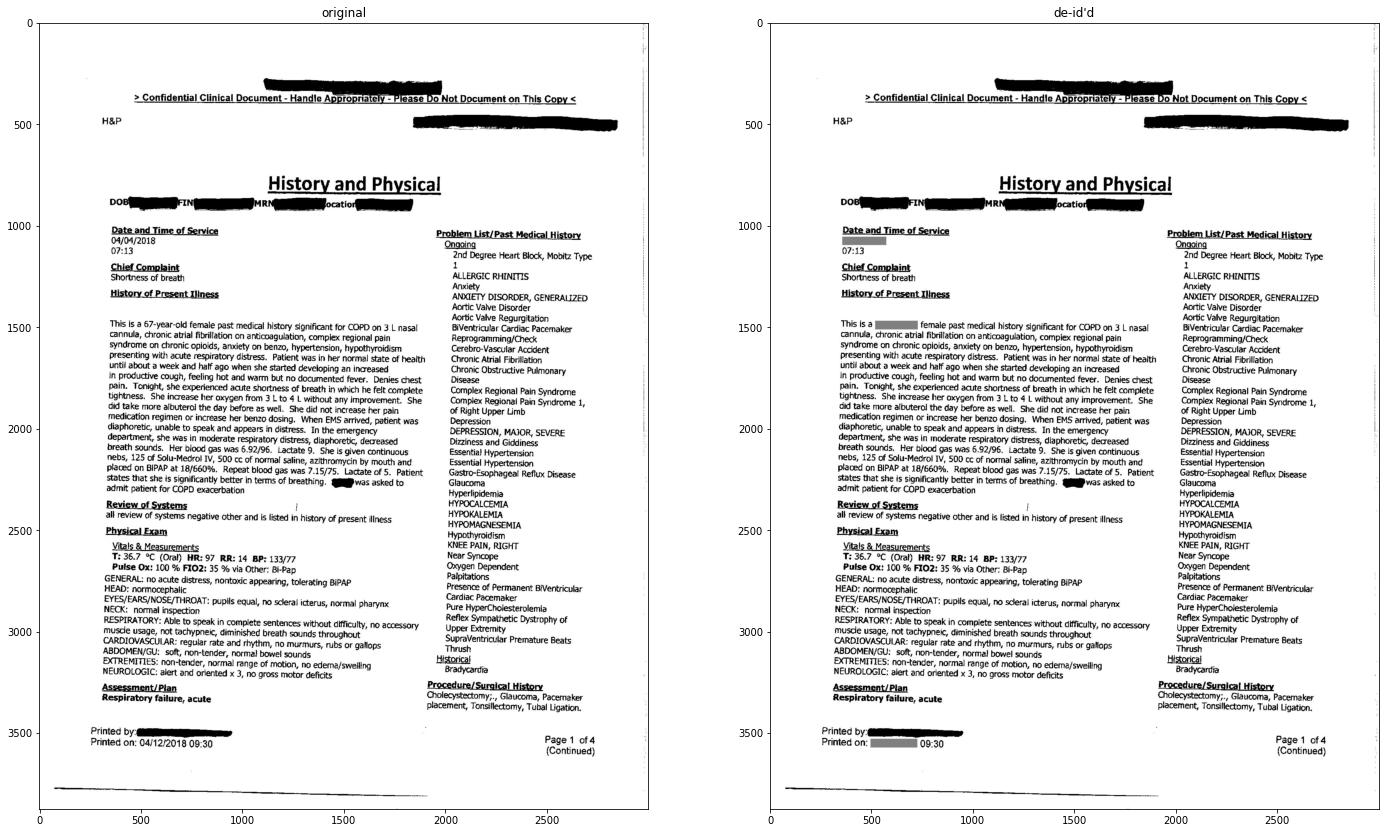

In [ ]:
# NBVAL_SKIP
for r in result.select("image_raw", "image_with_regions").collect():
    img_orig = r.image_raw
    img_deid = r.image_with_regions

    img_pil_orig = to_pil_image(img_orig, img_orig.mode)
    img_pil_deid = to_pil_image(img_deid, img_deid.mode)

    plt.figure(figsize=(24,16))
    plt.subplot(1, 2, 1)
    plt.imshow(img_pil_orig, cmap='gray')
    plt.title('original')
    plt.subplot(1, 2, 2)
    plt.imshow(img_pil_deid, cmap='gray')
    plt.title("de-id'd")
    plt.show()

In [ ]:
## Store result

In [ ]:
# NBVAL_SKIP
output_path = "././data/images/deidentified/"
if not os.path.exists(output_path):
    os.makedirs(output_path)

for r in result.select("image_with_regions", "path").collect():
    path, name = os.path.split(r.path)
    file_name = os.path.join(output_path, name)
    print(f"Storing to {file_name}")
    
    im = to_pil_image(r.image_with_regions, r.image_with_regions.mode)
    im.save(file_name)

Storing to ././data/images/deidentified/p1.jpg


## Remove reults

In [ ]:
%%bash
rm -r -f ././data/images/deidentified